In [1]:
%load_ext autoreload
%autoreload 2

# Change to Project Notebook Directory (Google Colab)


In [2]:
import os
os.chdir('/content/drive/MyDrive/projects/Tensorflow-tutorial-Daniel-Bourke/notebooks')
os.listdir()

['.ipynb_checkpoints',
 '03B-10-Food-Multiclass-Classification.ipynb',
 '04-Transfer-Learning-Part1-Feature-Extraction.ipynb',
 '01A-tensorflow-neural-network-regression.ipynb',
 '01B-tensorflow-neural-network-regression.ipynb',
 '00-tensorflow-fundamentals.ipynb',
 '05-Transfer-Learning-Part2-Fine-Tuning.ipynb',
 'Z-Check-Imports.ipynb',
 '02B-Fashion-MNIST-larger-example.ipynb',
 '03A-Pizza-Steak-Image-Classification.ipynb',
 '01C-tensorflow-neural-network-regression.ipynb',
 '06-Transfer-Learning-Part3-Food-Vision-Mini.ipynb',
 '02A-tensorflow-playground-reimplementation.ipynb',
 '07-Milestone-Project-1-Food-Vision-Big.ipynb',
 '08-NLP-Basics-in-Tensorflow-Disaster-Tweets.ipynb']

# 08-NLP-Basics-in-Tensorflow-Disaster-Tweets

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-example-nlp-problems.png)

* Webpage tag classification (multi-label classification)
* Machine translation (seq2seq)
    * Earlier encoder-decoder architecture without attention
    * Encoder-Decoder with attention (but still sequential processing i.e. non parellelized)
    * Newer attention models (parellelized) i.e. add sequence encoding as substitute for processing one timestep at one time

* Text Generation (seq2seq)
* Voice Assistants (Conversational AI, Speech recognition, trigger word detection, lots of different NLP tasks for a good chatbot)

* Other tasks: Customer complaint classification, feedback analyses post a service/chat with a customer executive


> **Note**: *Sequence* refers to the sequence of words. In language, the order of the words, the context matters. And also, the context can be somewhat far away from the actual word/phrase of interest. So there are long-range dependencies. Generally a sentence parse tree would make this more clear, that words are related to one-another even grammatically even though sequentially they maybe quite a few timesteps apart

[A Simple Introduction to Natural Language Processing](https://becominghuman.ai/a-simple-introduction-to-natural-language-processing-ea66a1747b32)

# Contents of this notebook

- [ ] Downloading a text dataset (disaster tweets)
- [ ] Visualizing text data
- [ ] Tokenize our dataset (Explore various preprocessing options)
- [ ] Turning our tokenized text into an embedding
- [ ] Create a baseline model with TF-IDF and Naive Bayes
- Build several deep learning models
    - [ ] Simple Dense
    - [ ] LSTM
    - [ ] GRU
    - [ ] Conv1D
    - [ ] Transfer Learning
- [ ] Compare the performance of our models
- [ ] Combining our models into an ensemble
- [ ] Saving and loading a trained model
- [ ] Find the most wrong prediction

## Disaster Tweets Data

* `train.csv`: training samples of real disaster and not real disaster tweets 
* `test.csv`: test samples
* `sample_submission.csv`: an example of the file for submission to Kaggle competition (how the model's prediction should look like)

### Some imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

### Load the data

In [4]:
df_train = pd.read_csv('../data/disaster_tweets/train.csv').sample(frac=1, random_state=42)
df_test = pd.read_csv('../data/disaster_tweets/test.csv')

In [5]:
df_train.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
CLASS_NAMES = ['normal tweet', 'disaster tweet']

The dataset has:

* **keyword**: Maybe this is what the user assigns as the keyword in the tweet, or some other algo (another ML) picks up a word which is closely related to disaster. And we have to use this info in addition to the tweet to predict if it's a disaster tweet or not
* **location**: Location of the tweet. (See the location mentioned in the tweet as well? -> correspondence?)
* **text**: This is the actual tweet, contains tweet specific words, emojis, symbols [@,#], short forms, urls etc. Requires a lot of cleaning.
* **target**: The actual target which we want to predict.
    * 1 = disaster
    * 0 = not disaster


In [7]:
# Counts of each class
from src.utils import get_series_group_counts
count_df = get_series_group_counts(df_train['target'])
count_df 

,count,prop
0,4342,0.57034
1,3271,0.42966


57% not real disaster and 42% real disaster tweets. This is a more or less binary classification task.

In [8]:
train_count = df_train.shape[0]
test_count = df_test.shape[0]
total_count = train_count + test_count
print(f'Total train samples:', train_count)
print(f'Total test samples:', test_count)
print(f'Train: {train_count*100/total_count:.2f}%, Test: {test_count*100/total_count:.2f}%')

Total train samples: 7613
Total test samples: 3263
Train: 70.00%, Test: 30.00%


We have a typical 70-30 split :)

## Visualize random datapoints

In [9]:
n = 5
rand_idx = np.random.randint(0, df_train.shape[0], size=n)

for i, row in df_train.loc[rand_idx, ['text', 'target']].iterrows():
    print('Target:' , row['target'], "(real disaster)" if row['target'] == 1 else '(not real disaster)')
    print('Tweet:\n', row['text'])
    print('----\n')
    

Target: 0 (not real disaster)
Tweet:
 @sarahmcpants @JustJon I'll give him a titty twister
----

Target: 0 (not real disaster)
Tweet:
 3 Options To Fix Your Facebook Cover Violation http://t.co/pF8dXwIbDp and Keep the #Facebook Police away. #socialmedia #strategy
----

Target: 0 (not real disaster)
Tweet:
 @QuotesTTG Save the panicking for when you get to Helios. ;)
----

Target: 1 (real disaster)
Tweet:
 There's a fire in the Catalinas. Looks kinda cool. This picture doesn't do it justice. https://t.co/N0tAwGeZJx
----

Target: 1 (real disaster)
Tweet:
 @TadhgTGMTEL dude was just smoking and the fucking thing went up in flames i though a bomb went off omg scared
----



## Split into training and validation datasets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
test_sents = df_test['text'].to_numpy()
test_sents

array(['Just happened a terrible car crash',
       'Heard about #earthquake is different cities, stay safe everyone.',
       'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
       ..., 'Green Line derailment in Chicago http://t.co/UtbXLcBIuY',
       'MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3',
       '#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm'],
      dtype=object)

In [12]:
train_sents, val_sents, train_labels, val_labels = train_test_split(df_train['text'].to_numpy(), df_train['target'].to_numpy(),
                                                                    test_size=0.2, random_state=42)


In [13]:
print('Train:', len(train_sents))
print('Validation:', len(val_sents))
print('Test:', len(test_sents))

Train: 6090
Validation: 1523
Test: 3263


In [114]:
RAW_TEXT_DATA_STORE = dict(zip(['train', 'validation', 'test'], [train_sents, val_sents, test_sents]))
LABEL_DATA_STORE = {'train': train_labels[:, np.newaxis], 'validation': val_labels[:, np.newaxis]}

In [15]:
# View first 10 train tweets and their labels
train_sents[:10], train_labels[:10]

(array(['Detonation fashionable mountaineering electronic watch water-resistant couples leisure tab\x89Û_ http://t.co/E61x9Y65QD http://t.co/OVLET0gDqm',
        "Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/tFan6qq2Ys http://t.co/rAkwWritPo",
        'I-77 Mile Marker 31 to 40 South Mooresville  Iredell Vehicle Accident Congestion at 8/6 1:18 PM',
        "#Greece's tax revenues collapse as debt crisis continues via @guardian #bailout http://t.co/cJvbQXw83s ^mp",
        'Be not afraid of sudden fear neither of the desolation of the wicked when it cometh. For the Lord shall be thy... http://t.co/bP597YDs2b',
        'Storm batters Auckland and Northland: A violent overnight storm has battered Auckland and Northland uprooting... http://t.co/enrPGRgtTs',
        "Benzema increasingly looks to be a casualty of Benitez's new look squad. Arsenal bound? 50-50 chance I think",
        'Acquire your postexistence straight a elevation in addition

## Converting text to numbers

> Before we pass our text tweets to the machine learning algorithm, we somehow have to convert them into numbers i.e. encode the information contained in the text in a somewhat meaningful textual representation.

In NLP, there are two main concepts to convert text into numbers:

1. **Tokenization** - This is basically converting a peice of text into a sequence of tokens. Each token is assigned a unique index in the corpus vocabulary. There are three main levels of tokenization:
    1. **word-level** tokenization: For a sentence, "I love data science", depending upon the tokenizer rules, this may be converted into \
    {'I': 0, 'love': 1, 'data': 2, 'science': 3}. As we encounter more words, each will be assigned its unique index in the vocab. 
    2. **character-level** tokenization: In this each letter [A-Za-z]/symbol[special chars]/digit[0-9] depending on the vocabulary chosen is assigned an unique index. Every character in the sentence is considered a separate token. 
    3. **sub-word** tokenization: This is somewhat between word-level and character-level. It involves breaking individual words into smaller sub-parts and then assigning each sub-part its unique index in the vocabulary. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". These subwords are decided based on their frequency to minimize the number of subword tokens to create. Hence, each word could be composed of multiple tokens. 

2. **Embeddings** - An embedding is the semantic meaning of a word/sentence/token encoded in a numerical representation. These are learned in an unsupervised way (mostly!) from large text corpus, through various ways
 - Embedding layer (your own custom embedding; learn from scratch or fine-tune existing) using `tf.keras.layers.Embedding`
 - Word2Vec: Continous BOW, Continous skip-gram (shallow NN)
 - GlOVe: Does not even use neural network
 - Fasttext
 - Bert embeddings
 - Many more...

 We can get these pretrained embeddings by either downloading these off the internet, or directly from the Tensorflow Hub. 

 For e.g. the word "love" can be `[-0.56, 0.98, 0.23, 0.87, 0.18]` if the embedding space is 5-dimensional. 

 ![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-tokenization-vs-embedding.png)

 > We can even stack multiple embeddings together to form larger dimensional embedding. For example stack general embedding (trained on general text such as Wikipedia), with domain specific embedding such as food review embedding. We can even keep on stacking multiple other features, for e.g. in word-level embedding, we can stack part of speech OHE vector and see if performance improves. 


## Text Vectorization (tokenization)

To tokenize our words, we'll use the preprocessing layer `tf.keras.layers.experimental.preprocessing.TextVectorization`

The `TextVectorization` layer takes the follwing arguments:

* `max_tokens`: Maximum number of tokens I want to keep in my vocabulary (say 10000), includes a value for OOV token.
* `standardize`: Method for standardizing text. Default is `lower_and_strip_punctuation` which lowers text and removes all punctuation marks
* `split` - How to split text, default is `whitespace`
* `ngrams` - How many words to contain per token. If `ngrams=2`, then uptill two ngrams taken to tokenize a sentence. Each unique two-at-a-time 
* `output_mode` - How to output tokens, can be `int` (integer mapping), `binary` - one-hot-encoding, `count` or `tf-idf`
* `output_sequence_length` - Limit maximum length of the output sequence to x tokens.
* `pad_to_max_tokens` - if `True` (default), pad shorter sequences with 0s (left or right)


In [16]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None,
                                    output_mode='int',
                                    output_sequence_length=None,
                                    pad_to_max_tokens=True)

text_vectorizer

(array([  89.,  385.,  716.,  976., 1066., 1157.,  872.,  558.,  221.,
          50.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <a list of 10 Patch objects>)

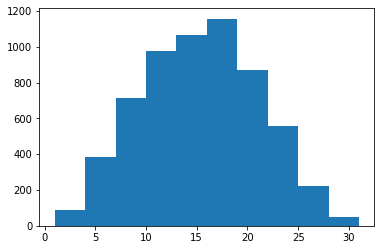

In [17]:
# Find average number of tokens (words) in training tweets
# Note: Somewhat wrong as this is not the actual complete tokenization procedure.
#       But roughly, this will be okayish.
token_lengths = [len(s.split()) for s in train_sents]
plt.hist(token_lengths)

In [18]:
np.percentile(token_lengths, 95)

24.0

Now we will create another text_vectorizer with custom options

In [19]:
MAX_VOCAB = 10000
MAX_SEQ_LENGTH = 24 # Cover 95% of the examples

text_vectorizer = TextVectorization(max_tokens=MAX_VOCAB,
                                    output_mode='int',
                                    output_sequence_length=MAX_SEQ_LENGTH)


To map our `TextVectorizer` instance `text_vectorizer` to our data, we call the `.adapt()` method (this is similar to `.fit` method of scikit-learn estimators)

In [20]:
text_vectorizer.adapt(train_sents)

Now, our `text_vectorizer` has adapted to the training tweets. Let us try to tokenize a custom sentence

In [21]:
my_tweet = "It has been raining the whole day. My place is gonna flood so heavily!"
text_vectorizer([my_tweet])

<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
array([[  15,   39,   61, 2553,    2,  309,   93,   13,  591,    9,  358,
         229,   27,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]])>

The 0s at the end are the padding tokens since the tokenized sentence length is less than the max_tokens = 24

In [22]:
# Tokenize a random sentence
rand_sent = np.random.choice(train_sents)
print('Original Sentence:\n', rand_sent, '\n----\n')
print('Tokenized Sentence:\n', text_vectorizer([rand_sent]))

Original Sentence:
 Sorrower  - Fresh Wounds Over Old Scars  (2015 Death Metal) http://t.co/L056yj2IOi http://t.co/uTMWMjiRty 
----

Tokenized Sentence:
 tf.Tensor(
[[7640 2273  615   56  210 3166  203  160 1090    1    1    0    0    0
     0    0    0    0    0    0    0    0    0    0]], shape=(1, 24), dtype=int64)


In [23]:
words_in_vocab = text_vectorizer.get_vocabulary()
print('Number of words in vocab:', len(words_in_vocab))
print('Top 5 words:', words_in_vocab[:5])
print('Bottom 5 words:', words_in_vocab[-5:])

Number of words in vocab: 10000
Top 5 words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 words: ['minded', 'mindblowing', 'milne', 'milledgeville', 'millcityio']


## Create an embedding using an `Embedding` Layer

The arguments of the Embedding layer `tf.keras.layers.Embedding`:

* `input_dim` - The size of the vocabulary
* `output_dim` - The size of the output embedding vector. How much information you want to encode (in case we want to learn)?
* `embeddings_initializer` - How to initialize the embedding matrix, default is `uniform` which randomly initializes embedding matrix with uniform distribution. This can also be any prelearned embedding
* `input_length` - Length of sequences being passed to the embedding layer

In [24]:
from tensorflow.keras import layers

EMBEDDING_DIM = 128

embedding_layer = layers.Embedding(input_dim=MAX_VOCAB, output_dim=EMBEDDING_DIM, 
                                   embeddings_initializer='uniform',
                                   input_length=MAX_SEQ_LENGTH)
embedding_layer

Let's try to convert a random sentence into a embeddings

In [25]:
rand_sent = np.random.choice(train_sents)
print('Original sentence:\n', rand_sent, '\n----\n')

sent_tokens = text_vectorizer([rand_sent])
print('Tokenized sentence:\n', sent_tokens, '\n----\n')

sent_embed = embedding_layer(text_vectorizer([rand_sent]))
print('Embedded sentence:\n', sent_embed)

Original sentence:
 Savs contact fell out but she was convinced it didnt &amp; went on to guage her eyeball out &amp; now shes having a panic attack over caused damage 
----

Tokenized sentence:
 tf.Tensor(
[[8100 5445 1954   36   30  208   23    1   15  538   35  487   11    5
     1   78    1   36   35   49  891  704    3  280]], shape=(1, 24), dtype=int64) 
----

Embedded sentence:
 tf.Tensor(
[[[ 0.03740037 -0.04649572 -0.01458937 ...  0.01652699 -0.0435478
    0.01532007]
  [-0.00673969 -0.03489799  0.01911301 ...  0.03568185 -0.01400198
    0.00177767]
  [-0.04128673 -0.04316599 -0.02262585 ... -0.03444166  0.02329406
   -0.00594489]
  ...
  [-0.03369343 -0.0354238  -0.01101648 ...  0.04587121 -0.04884961
   -0.03935236]
  [-0.04032039 -0.02426467  0.04171933 ... -0.03174298  0.02999883
    0.03725635]
  [ 0.01224661 -0.04107964  0.01857345 ...  0.0113674  -0.0289698
   -0.02715782]]], shape=(1, 24, 128), dtype=float32)


The embedding layer converts a list of tokens to a list of embeddings of each token of dimensionality = 128.

## Modelling a text dataset
![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-inputs-and-outputs-with-shapes-and-models-were-going-to-build.png)

> **Note**: Here the tweets is converted to a matrix [None, 512]. This is because, after getting 24 word embeddings for each token in the sentence, usually we average out the word embeddings. 


Models we will build:

* **Model 0**: Naive Bayes (baseline model)
* **Model 1**: Simple Dense NN 
* **Model 2**: LSTM 
* **Model 3**: GRU
* **Model 4**: Bidirectional-LSTM
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: Tensorflow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data


### Storing the model predictions

In [26]:
MODELS = {}
PRED_FUNCS = {}
PREDICTIONS = {}

## Model 0: Naive Bayes (Baseline)

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [28]:
model_name = 'baseline-naive-bayes'


In [29]:
model = Pipeline([
                  ('tfidf', TfidfVectorizer()),
                  ('clf', MultinomialNB())]
                 )

model.fit(train_sents, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [30]:
MODELS[model_name] = model


In [31]:
baseline_score = model.score(val_sents, val_labels)
baseline_score*100

79.9080761654629

In [32]:
from src.utils import reshape_classification_prediction

In [33]:
PREDICTIONS[model_name] = {}
for subset, X in RAW_TEXT_DATA_STORE.items():
    PREDICTIONS[model_name][subset] = reshape_classification_prediction(model.predict_proba(X))


In [34]:
y_pred = PREDICTIONS[model_name]['validation']
y_true = LABEL_DATA_STORE['validation']
print(classification_report(y_true, y_pred.round(), 
                            target_names=['normal tweet', 'disaster tweet']))

                precision    recall  f1-score   support

  normal tweet       0.76      0.94      0.84       858
disaster tweet       0.88      0.62      0.73       665

      accuracy                           0.80      1523
     macro avg       0.82      0.78      0.79      1523
  weighted avg       0.81      0.80      0.79      1523



## Model 1: Simple Dense Neural Network 

In [35]:
from src.evaluate import KerasMetrics
from src.visualize import plot_learning_curve

In [36]:
model_name = 'simple-dense'

### Create the model

In [37]:
inputs = layers.Input(shape=(1,), dtype='string')
vec = text_vectorizer(inputs)
emb = embedding_layer(vec)
pooled = layers.GlobalAvgPool1D()(emb)
outputs = layers.Dense(1, activation='sigmoid')(pooled)

model = tf.keras.models.Model(inputs, outputs, name=model_name)

model.compile(loss='binary_crossentropy', optimizer='Adam',
              metrics=['accuracy', KerasMetrics.f1])

### Fit the model

In [38]:
history = model.fit(train_sents, train_labels, validation_data=(val_sents, val_labels),
                    epochs=10, batch_size=32)
MODELS[model_name] = model

Epoch 1/10
191/191 [==============================] - 5s 19ms/step - loss: 0.6407 - accuracy: 0.6342 - f1: 0.2325 - val_loss: 0.5812 - val_accuracy: 0.7354 - val_f1: 0.5835
Epoch 2/10
191/191 [==============================] - 3s 17ms/step - loss: 0.4907 - accuracy: 0.8043 - f1: 0.7160 - val_loss: 0.4930 - val_accuracy: 0.7846 - val_f1: 0.7114
Epoch 3/10
191/191 [==============================] - 3s 17ms/step - loss: 0.3849 - accuracy: 0.8514 - f1: 0.8025 - val_loss: 0.4656 - val_accuracy: 0.7997 - val_f1: 0.7420
Epoch 4/10
191/191 [==============================] - 3s 17ms/step - loss: 0.3181 - accuracy: 0.8782 - f1: 0.8417 - val_loss: 0.4603 - val_accuracy: 0.7951 - val_f1: 0.7421
Epoch 5/10
191/191 [==============================] - 3s 17ms/step - loss: 0.2680 - accuracy: 0.9003 - f1: 0.8725 - val_loss: 0.4675 - val_accuracy: 0.7991 - val_f1: 0.7464
Epoch 6/10
191/191 [==============================] - 3s 17ms/step - loss: 0.2278 - accuracy: 0.9200 - f1: 0.8992 - val_loss: 0.4801 - 

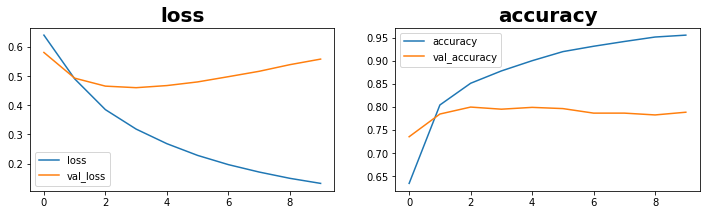

In [39]:
plot_learning_curve(model, extra_metric='accuracy');

Definitely overfitted! This is due to the fact that we have our embedding layer also trainable.

In [40]:
PREDICTIONS[model_name] = {}
for subset, X in RAW_TEXT_DATA_STORE.items():
    PREDICTIONS[model_name][subset] = reshape_classification_prediction(model.predict(X))


## Model 2: LSTM

In [41]:
model_name = 'LSTM'

In [42]:
inputs = layers.Input(shape=(1,), dtype='string')
vec = text_vectorizer(inputs)
emb = embedding_layer(vec)
x = layers.LSTM(units=64)(emb)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs, outputs, name=model_name)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
model.fit(train_sents, train_labels, validation_data=(val_sents, val_labels),
          epochs=10, batch_size=32)

Epoch 1/10
191/191 [==============================] - 9s 37ms/step - loss: 0.1711 - accuracy: 0.9420 - val_loss: 0.6288 - val_accuracy: 0.7859
Epoch 2/10
191/191 [==============================] - 7s 34ms/step - loss: 0.0924 - accuracy: 0.9683 - val_loss: 0.7466 - val_accuracy: 0.7807
Epoch 3/10
191/191 [==============================] - 7s 36ms/step - loss: 0.0803 - accuracy: 0.9696 - val_loss: 0.8294 - val_accuracy: 0.7787
Epoch 4/10
191/191 [==============================] - 7s 36ms/step - loss: 0.0703 - accuracy: 0.9737 - val_loss: 0.6745 - val_accuracy: 0.7800
Epoch 5/10
191/191 [==============================] - 7s 37ms/step - loss: 0.0579 - accuracy: 0.9764 - val_loss: 1.0678 - val_accuracy: 0.7715
Epoch 6/10
191/191 [==============================] - 7s 36ms/step - loss: 0.0572 - accuracy: 0.9744 - val_loss: 1.1133 - val_accuracy: 0.7748
Epoch 7/10
191/191 [==============================] - 7s 34ms/step - loss: 0.0470 - accuracy: 0.9803 - val_loss: 1.0326 - val_accuracy: 0.7807

In [44]:
MODELS[model_name] = model

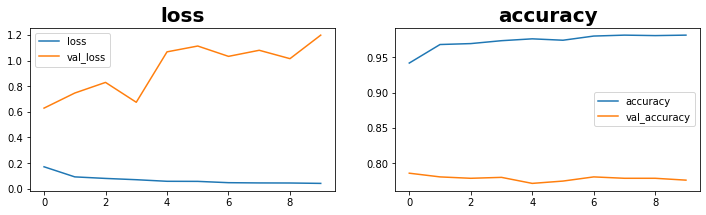

In [45]:
plot_learning_curve(model, extra_metric='accuracy');

This too is also highly overfitted, mainly due to the trainable embedding layer.

In [46]:
PREDICTIONS[model_name] = {}
for subset, X in RAW_TEXT_DATA_STORE.items():
    PREDICTIONS[model_name][subset] = reshape_classification_prediction(model.predict(X))


## Model 3: GRU

In [47]:
model_name = 'GRU'

In [48]:
inputs = layers.Input(shape=(1,), dtype='string')
vec = text_vectorizer(inputs)
emb = embedding_layer(vec)
x = layers.GRU(units=64)(emb)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs, outputs, name=model_name)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
model.fit(train_sents, train_labels, validation_data=(val_sents, val_labels),
          epochs=10, batch_size=32)
MODELS[model_name] = model

Epoch 1/10
191/191 [==============================] - 9s 37ms/step - loss: 0.1692 - accuracy: 0.9161 - val_loss: 0.8266 - val_accuracy: 0.7754
Epoch 2/10
191/191 [==============================] - 7s 35ms/step - loss: 0.0578 - accuracy: 0.9785 - val_loss: 0.7400 - val_accuracy: 0.7682
Epoch 3/10
191/191 [==============================] - 6s 34ms/step - loss: 0.0493 - accuracy: 0.9810 - val_loss: 1.0759 - val_accuracy: 0.7748
Epoch 4/10
191/191 [==============================] - 6s 33ms/step - loss: 0.0406 - accuracy: 0.9819 - val_loss: 1.3152 - val_accuracy: 0.7656
Epoch 5/10
191/191 [==============================] - 6s 33ms/step - loss: 0.0803 - accuracy: 0.9685 - val_loss: 0.9957 - val_accuracy: 0.7636
Epoch 6/10
191/191 [==============================] - 6s 33ms/step - loss: 0.0382 - accuracy: 0.9813 - val_loss: 1.1726 - val_accuracy: 0.7511
Epoch 7/10
191/191 [==============================] - 6s 33ms/step - loss: 0.0330 - accuracy: 0.9839 - val_loss: 1.3503 - val_accuracy: 0.7781

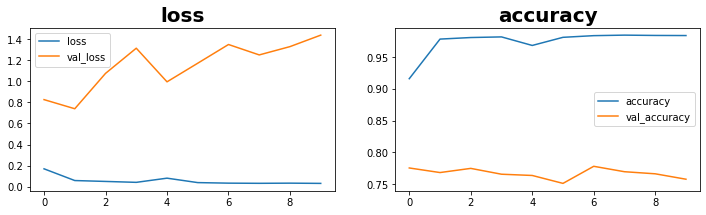

In [50]:
plot_learning_curve(model, extra_metric='accuracy');

Again highly overfitted due to the trainable embedding.

In [51]:
PREDICTIONS[model_name] = {}
for subset, X in RAW_TEXT_DATA_STORE.items():
    PREDICTIONS[model_name][subset] = reshape_classification_prediction(model.predict(X))


## Model 4: Bidirectional-LSTM

In [52]:
model_name = 'Bidirectional-LSTM'

In [53]:
inputs = layers.Input(shape=(1,), dtype='string')
vec = text_vectorizer(inputs)
emb = embedding_layer(vec)
x = layers.Bidirectional(layers.LSTM(units=64))(emb)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs, outputs, name=model_name)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
history = model.fit(train_sents, train_labels, validation_data=(val_sents, val_labels),
                    epochs=10, batch_size=32)
MODELS[model_name] = model

Epoch 1/10
191/191 [==============================] - 13s 52ms/step - loss: 0.0848 - accuracy: 0.9737 - val_loss: 1.0501 - val_accuracy: 0.7715
Epoch 2/10
191/191 [==============================] - 9s 48ms/step - loss: 0.0369 - accuracy: 0.9828 - val_loss: 1.1882 - val_accuracy: 0.7643
Epoch 3/10
191/191 [==============================] - 9s 49ms/step - loss: 0.0317 - accuracy: 0.9849 - val_loss: 1.2247 - val_accuracy: 0.7571
Epoch 4/10
191/191 [==============================] - 10s 50ms/step - loss: 0.0297 - accuracy: 0.9846 - val_loss: 1.1745 - val_accuracy: 0.7649
Epoch 5/10
191/191 [==============================] - 9s 49ms/step - loss: 0.0413 - accuracy: 0.9801 - val_loss: 1.1403 - val_accuracy: 0.7636
Epoch 6/10
191/191 [==============================] - 9s 49ms/step - loss: 0.0334 - accuracy: 0.9839 - val_loss: 1.3559 - val_accuracy: 0.7630
Epoch 7/10
191/191 [==============================] - 9s 49ms/step - loss: 0.0292 - accuracy: 0.9844 - val_loss: 1.3636 - val_accuracy: 0.74

(<Figure size 864x216 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f82cbd1cc90>,
       dtype=object))

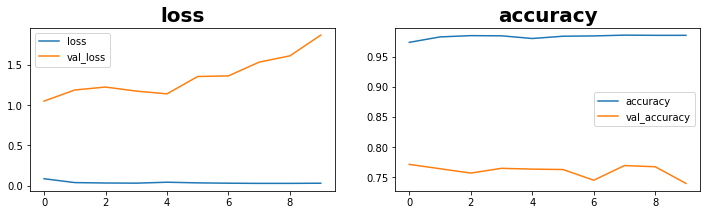

In [55]:
plot_learning_curve(model, extra_metric='accuracy')

In [56]:
PREDICTIONS[model_name] = {}
for subset, X in RAW_TEXT_DATA_STORE.items():
    PREDICTIONS[model_name][subset] = reshape_classification_prediction(model.predict(X))


## Model 5: CNN

In [57]:
model_name = 'CNN'

In [58]:
inputs = layers.Input(shape=(1,), dtype='string')
vec = text_vectorizer(inputs)
emb = embedding_layer(vec)
x = layers.Conv1D(filters=32, kernel_size=5, activation='relu')(emb)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs, outputs, name=model_name)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 20, 32)            20512     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,300,545
Trainable params: 1,300,545
Non-trainable params: 0
_____________________________________________________

In [59]:
history = model.fit(train_sents, train_labels, validation_data=(val_sents, val_labels),
                    epochs=10, batch_size=32)
MODELS[model_name] = model

Epoch 1/10
191/191 [==============================] - 5s 25ms/step - loss: 0.1025 - accuracy: 0.9688 - val_loss: 0.9168 - val_accuracy: 0.7630
Epoch 2/10
191/191 [==============================] - 4s 22ms/step - loss: 0.0566 - accuracy: 0.9790 - val_loss: 1.0708 - val_accuracy: 0.7695
Epoch 3/10
191/191 [==============================] - 4s 21ms/step - loss: 0.0463 - accuracy: 0.9821 - val_loss: 1.1883 - val_accuracy: 0.7649
Epoch 4/10
191/191 [==============================] - 4s 21ms/step - loss: 0.0403 - accuracy: 0.9836 - val_loss: 1.2514 - val_accuracy: 0.7649
Epoch 5/10
191/191 [==============================] - 4s 22ms/step - loss: 0.0400 - accuracy: 0.9823 - val_loss: 1.2921 - val_accuracy: 0.7669
Epoch 6/10
191/191 [==============================] - 4s 22ms/step - loss: 0.0367 - accuracy: 0.9829 - val_loss: 1.3564 - val_accuracy: 0.7676
Epoch 7/10
191/191 [==============================] - 4s 22ms/step - loss: 0.0363 - accuracy: 0.9837 - val_loss: 1.3283 - val_accuracy: 0.7603

(<Figure size 864x216 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f82caaed990>,
       dtype=object))

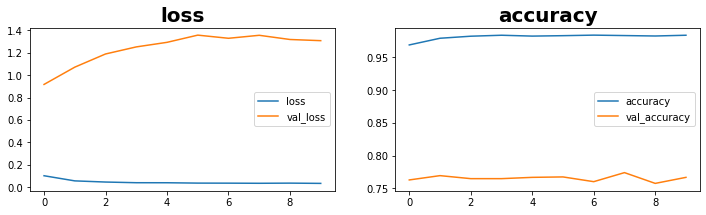

In [60]:
plot_learning_curve(model, extra_metric='accuracy')

Again, again very overfitted due to trainable embedding

In [61]:
PREDICTIONS[model_name] = {}
for subset, X in RAW_TEXT_DATA_STORE.items():
    PREDICTIONS[model_name][subset] = reshape_classification_prediction(model.predict(X))


## Using Pretrained Embeddings (transfer learning for NLP)

In the previous experiments, we trained the 128 dimensional embeddings from scratch which was the main reason for overfitting. Using pretrained embeddings is a type of **transfer learning**, which leverages the knowledge about language/words learned from large text corpus. These can be fine-tuned for our specific task.

In the next model, we will replace the embedding layer with pretrained embeddings:
* We can use embedding data downloaded off the internet and initialize the embedding layer with these vectors. 
* Or we can use a pretrained embedding layer download from TensorflowHub.


We will use the [Universal Sentence Encoder](https://www.aclweb.org/anthology/D18-2029.pdf) from [Tensorflow Hub](https://tfhub.dev/google/universal-sentence-encoder/4)




## Model 6: Tensorflow Hub Pretrained Sentence Encoder

* Rather than create a word level embedding, the Universal Sentence Encoder creates a sentence level embedding (hence the name)
* The embedding that we trained outputted a 128 dimensional vector for each word, where as the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-USE-tensorflow-hub-encoder-decoder-model.png)


The model that we are building follows from the concept of Encoder-Decoder architecture:

* **Encoder** is a model which takes the inputs and encodes it appropriately in a numeric representation, a **Decoder** takes that encoded information and decodes the desired output.
* Here the **Universal Sentence Encoder** encodes the information in the sentence in a 512 dimensional numerical representation. The architecture that proceeds from there will be our **decoder** part of the model.


In [63]:
import tensorflow_hub as tfhub

url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
embed_obj = tfhub.load(url)
sent = 'Omg there is a fire near my house!!!'
embed_sent = embed_obj([sent])

In [64]:
embed_sent.shape # 1 sentence passed => 512 dimensional embedding

TensorShape([1, 512])

In [65]:
embed_obj

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f82c8832350>

Let us convert the `embed_obj` into a `KerasLayer` so that we can easily use it in our model

In [67]:
sent_encode_layer = tfhub.KerasLayer(embed_obj, input_shape=[],
                                     dtype=tf.string, trainable=False, name='USE')
sent_encode_layer

In [68]:
model_name = 'USE-Simple-Dense'

In [69]:
model = tf.keras.models.Sequential([
    sent_encode_layer,
    layers.Dropout(0.5), # Avoiding overfitting due to most parameters in this layer
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name=model_name)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "USE-Simple-Dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


Very less trainable params due to the embedding layer not being trainable. Hopefully this would avoid overfitting.

In [70]:
model.fit(train_sents, train_labels, validation_data=(val_sents, val_labels),
          epochs=10, batch_size=32)
MODELS[model_name] = model

Epoch 1/10
191/191 [==============================] - 6s 17ms/step - loss: 0.5435 - accuracy: 0.7514 - val_loss: 0.4617 - val_accuracy: 0.7958
Epoch 2/10
191/191 [==============================] - 3s 13ms/step - loss: 0.4461 - accuracy: 0.8018 - val_loss: 0.4432 - val_accuracy: 0.7958
Epoch 3/10
191/191 [==============================] - 3s 13ms/step - loss: 0.4316 - accuracy: 0.8011 - val_loss: 0.4381 - val_accuracy: 0.8011
Epoch 4/10
191/191 [==============================] - 2s 13ms/step - loss: 0.4276 - accuracy: 0.8080 - val_loss: 0.4377 - val_accuracy: 0.8070
Epoch 5/10
191/191 [==============================] - 3s 13ms/step - loss: 0.4296 - accuracy: 0.8031 - val_loss: 0.4374 - val_accuracy: 0.8011
Epoch 6/10
191/191 [==============================] - 3s 13ms/step - loss: 0.4228 - accuracy: 0.8095 - val_loss: 0.4346 - val_accuracy: 0.8063
Epoch 7/10
191/191 [==============================] - 3s 13ms/step - loss: 0.4227 - accuracy: 0.8095 - val_loss: 0.4305 - val_accuracy: 0.7991

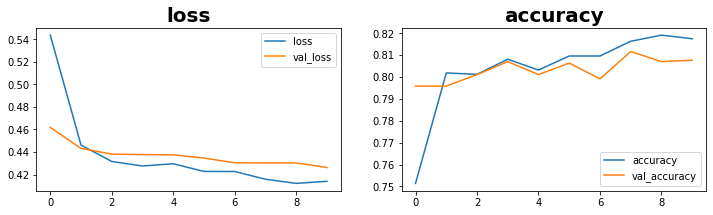

In [71]:
plot_learning_curve(model, extra_metric='accuracy');

This performs way way better! **Universal Sentence Encoder** i.e. pretrained embeddings (with `trainable=False`) reduced the number of paramaters to train + Adding a `Dropout` layer dramatically reduced overfitting!

In [72]:
PREDICTIONS[model_name] = {}
for subset, X in RAW_TEXT_DATA_STORE.items():
    PREDICTIONS[model_name][subset] = reshape_classification_prediction(model.predict(X))


## Model 7: Tensorflow Hub pretrained sentence encoder with 10% of the training data

This is one of the main benefits of using transfer learning is that you can use much lesser data, hence saving computation time, requiring lesser memory, and faster iteration in experimentation. 

In [73]:
from src.utils import sample_numpy_array

In [74]:
train_sents_small, train_labels_small = sample_numpy_array(train_sents, train_labels, prop=0.1)

In [75]:
print('Total train samples:', train_sents.size)
print('Small train samples:', train_sents_small.size)

Total train samples: 6090
Small train samples: 609


In [76]:
pd.Series(train_labels_small).value_counts()

0    359
1    250
dtype: int64

In [77]:
model_name = 'USE-Simple-Dense-10-percent'


In [78]:
# raises: NotImplementedError: Can only generate a valid config for `hub.KerasLayer(handle, ...)`that uses a string `handle`.
# If we had generated the KerasLayer for sent_encode_layer using a string url, it will still be supported
model = tf.keras.models.Sequential([
    sent_encode_layer,
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name=model_name)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [79]:
model.fit(train_sents_small, train_labels_small, validation_data=(val_sents, val_labels),
          batch_size=32, epochs=10)
MODELS[model_name] = model

Epoch 1/10
20/20 [==============================] - 2s 54ms/step - loss: 0.6828 - accuracy: 0.5895 - val_loss: 0.6681 - val_accuracy: 0.6796
Epoch 2/10
20/20 [==============================] - 1s 32ms/step - loss: 0.6497 - accuracy: 0.7274 - val_loss: 0.6371 - val_accuracy: 0.7315
Epoch 3/10
20/20 [==============================] - 1s 33ms/step - loss: 0.6132 - accuracy: 0.7718 - val_loss: 0.6028 - val_accuracy: 0.7702
Epoch 4/10
20/20 [==============================] - 1s 32ms/step - loss: 0.5775 - accuracy: 0.7915 - val_loss: 0.5702 - val_accuracy: 0.7748
Epoch 5/10
20/20 [==============================] - 1s 32ms/step - loss: 0.5467 - accuracy: 0.7734 - val_loss: 0.5448 - val_accuracy: 0.7702
Epoch 6/10
20/20 [==============================] - 1s 33ms/step - loss: 0.5161 - accuracy: 0.7964 - val_loss: 0.5216 - val_accuracy: 0.7820
Epoch 7/10
20/20 [==============================] - 1s 32ms/step - loss: 0.4898 - accuracy: 0.8030 - val_loss: 0.5042 - val_accuracy: 0.7840
Epoch 8/10
20

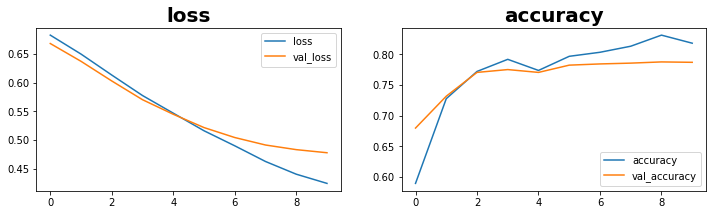

In [80]:
plot_learning_curve(model, extra_metric='accuracy');

In [81]:
PREDICTIONS[model_name] = {}
for subset, X in RAW_TEXT_DATA_STORE.items():
    PREDICTIONS[model_name][subset] = reshape_classification_prediction(model.predict(X))


## Combining our models (model ensembling/stacking)

* We can combine the predictions from our best models to make an ensemble for better predictions.
* The idea behind ensemble model is that, if several **uncorrelated** models agree on a prediction, then the confidence that it is correct increases. **Uncorrelated**, basically refers to that the model must be somewhat different to each other, in the way they learn the patterns.
    * **Analogy**: If you and your friends have the same taste in food, you will end up picking the same restaurant, but if all have somewhat different tastes, then the final restaurant that is picked by majorly all, must be a good restaurant.


Different ways of combining the models in an ensemble:

1. **Averaging** - Average out the prediction from each model
2. **Majority vote (mode)** - Take the majority class predicted by all the models as the actual prediction.
3. **Model Stacking** - Take the output predictions of each of the model and use as inputs to another model (meta classifier)

In [82]:
train_preds = {model: d['train'] for model, d in PREDICTIONS.items()}
val_preds = {model: d['validation'] for model, d in PREDICTIONS.items()}

In [83]:
from src.evaluate import ClassificationPerformanceComparer

clf_comp_train = ClassificationPerformanceComparer.from_predictions(
    predictions=list(train_preds.values()), data=(RAW_TEXT_DATA_STORE['train'],LABEL_DATA_STORE['train']),
    model_names=list(train_preds.keys()), class_names=CLASS_NAMES)

clf_comp_val = ClassificationPerformanceComparer.from_predictions(
    predictions=list(val_preds.values()), data=(RAW_TEXT_DATA_STORE['validation'],LABEL_DATA_STORE['validation']),
    model_names=list(val_preds.keys()), class_names=CLASS_NAMES)


In [84]:
clf_comp_val.calculate_metric_comparison_df()

In [85]:
top_n = 3
d = clf_comp_val.compdf_small
top_n_model_names = d.loc[d['metric'] == 'accuracy'].sort_values('value', ascending=False)['model'].iloc[:top_n].tolist()
top_n_model_names


['USE-Simple-Dense', 'baseline-naive-bayes', 'simple-dense']

In [88]:
ensemble_pred_dict = {'train': [], 'validation': [], 'test': []}
for name in top_n_model_names:
    pred_dict = PREDICTIONS[name]
    for subset, pred in pred_dict.items():
        ensemble_pred_dict[subset].append(pred)



ensemble_pred_dict = {subset: np.concatenate(pred, axis=1) for subset, pred in ensemble_pred_dict.items()}
    

In [89]:
for subset, pred in ensemble_pred_dict.items():
    print(subset, pred.shape)

train (6090, 3)
validation (1523, 3)
test (3263, 3)


In [90]:
for subset, pred in PREDICTIONS['baseline-naive-bayes'].items():
    print(subset, pred.shape)

train (6090, 1)
validation (1523, 1)
test (3263, 1)


### Ensemble-top3-avg

In [91]:
model_name = 'ensemble-top3-avg'

In [92]:
PREDICTIONS[model_name] = {}
for subset, pred in ensemble_pred_dict.items():
    PREDICTIONS[model_name][subset] = ensemble_pred_dict[subset].mean(axis=1)[:, np.newaxis]


### Ensemble-top3-majority

In [99]:
model_name = 'ensemble-top3-majority'


In [100]:
import scipy

In [101]:
PREDICTIONS[model_name] = {}
for subset, pred in ensemble_pred_dict.items():
    PREDICTIONS[model_name][subset] = scipy.stats.mode(ensemble_pred_dict[subset].round().astype(int), axis=1)[0]
    

## Ensemble-top3-meta-classifier

In [102]:
model_name = 'ensemble-top3-meta-classifier'

In [103]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(ensemble_pred_dict['train'], LABEL_DATA_STORE['train'])


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [104]:
PREDICTIONS[model_name] = {}
for subset, pred in ensemble_pred_dict.items():
    PREDICTIONS[model_name][subset] = reshape_classification_prediction(clf.predict(pred))
    

## Comparison of model performance

In [105]:
train_preds = {model: d['train'] for model, d in PREDICTIONS.items()}
val_preds = {model: d['validation'] for model, d in PREDICTIONS.items()}

In [106]:
from src.evaluate import ClassificationPerformanceComparer

clf_comp_train = ClassificationPerformanceComparer.from_predictions(
    predictions=list(train_preds.values()), data=(RAW_TEXT_DATA_STORE['train'],LABEL_DATA_STORE['train']),
    model_names=list(train_preds.keys()), class_names=CLASS_NAMES)

clf_comp_val = ClassificationPerformanceComparer.from_predictions(
    predictions=list(val_preds.values()), data=(RAW_TEXT_DATA_STORE['validation'],LABEL_DATA_STORE['validation']),
    model_names=list(val_preds.keys()), class_names=CLASS_NAMES)


In [107]:
clf_comp_train.calculate_metric_comparison_df()
clf_comp_val.calculate_metric_comparison_df()

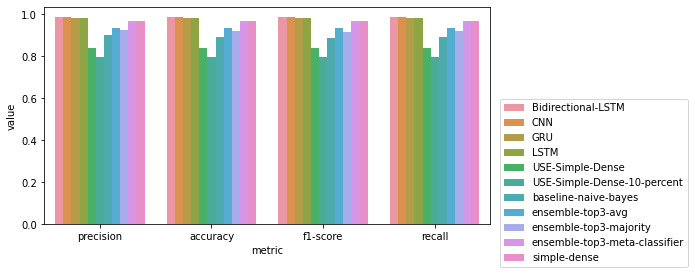

In [108]:
clf_comp_train.plot_metric_comparison_df()

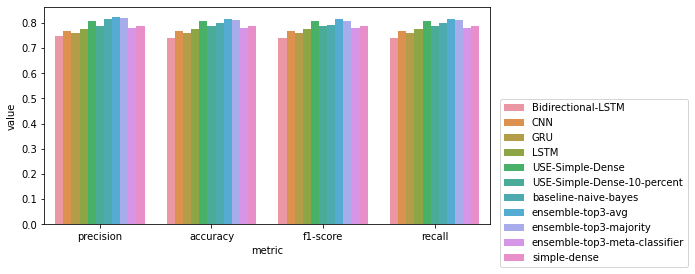

In [109]:
clf_comp_val.plot_metric_comparison_df()

For training set:

* **Simple-Dense** has the highest accuracy and **USE-Simple-Dense-10-percent** has the lowest accuracy.

For validation set:
* **ensemble-top3-avg** has the highest accuracy (very close to training accuracy) and hence is appropriately fitted!
* The second best model is the simplest one i.e. **baseline-naive-bayes** beating all the complex neural networks we created. 


We can probably tune the **ensemble-top3-meta-classifier** to acheive a better accuracy.

## Finding the most wrong examples

- Those predictions which are wrong but are predicted with a high confidence. Let us do it for one model i.e. **ensemble-top3-avg**

In [133]:
model_name = 'ensemble-top3-avg'
subset = 'validation'

In [134]:
text = RAW_TEXT_DATA_STORE[subset]
pred_probs = PREDICTIONS[model_name][subset]
preds = pred_probs.round().astype(int)
true = LABEL_DATA_STORE[subset]


In [135]:
pred_df = pd.DataFrame(dict(zip(['text', 'pred_prob', 'pred', 'true'], [np.squeeze(arr) for arr in [text, pred_probs, preds, true]])))
pred_df

,text,pred_prob,pred,true
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0.494562,0,0
1,FedEx no longer to transport bioterror germs i...,0.803715,1,0
2,Gunmen kill four in El Salvador bus attack: Su...,0.947295,1,1
3,@camilacabello97 Internally and externally scr...,0.167975,0,1
4,Radiation emergency #preparedness starts with ...,0.479118,0,1
...,...,...,...,...
1518,@SidelineSavage what like a pipe made of peanu...,0.088532,0,0
1519,Avalanche City - Sunset http://t.co/48h3tLvLXr...,0.232399,0,1
1520,The Whirlwind! Scourge of Europe! RT @whedones...,0.437282,0,0
1521,ENGLAND EAST COAST. Dogger Bank Westward. 1. S...,0.716740,1,0


In [138]:
is_wrong = pred_df['pred'] != pred_df['true']
most_wrong_preds = pred_df.loc[is_wrong].sort_values('pred_prob', ascending=False)
most_wrong_preds

,text,pred_prob,pred,true
846,Mourning notices for stabbing arson victims st...,0.928535,1,0
881,@adorableappple No reported flooding po in the...,0.916512,1,0
1502,Two Jewish Terrorists Charged In Historic-Chur...,0.898400,1,0
1363,Governor weighs parole for California school b...,0.871002,1,0
1307,We should all have a fire safety plan. RT @Mat...,0.869083,1,0
...,...,...,...,...
935,'I did another one I did another one. You stil...,0.049132,0,1
1391,I can't drown my demons they know how to swim,0.045541,0,1
408,@willienelson We need help! Horses will die!Pl...,0.044643,0,1
38,Why are you deluged with low self-image? Take ...,0.041327,0,1


 #### Most wrong False Positives

In [149]:
for i, row in most_wrong_preds[:10].iterrows():
    print('Target: {true}, Predicted: {pred}, Prob: {pred_prob:.2f}'.format(**row))
    print(row['text'])
    print('----\n')

Target: 0, Predicted: 1, Prob: 0.93
Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel: Posters for Shira Banki and A... http://t.co/3GZ5zQQTHe
----

Target: 0, Predicted: 1, Prob: 0.92
@adorableappple No reported flooding po in the area. Ten-4. #mmda
----

Target: 0, Predicted: 1, Prob: 0.90
Two Jewish Terrorists Charged In Historic-Church Arson | The Ugly Truth http://t.co/iEksNFSbY7 http://t.co/VWCf3slkrW
----

Target: 0, Predicted: 1, Prob: 0.87
Governor weighs parole for California school bus hijacker http://t.co/7NPBfRzEJL http://t.co/Y0kByy8nce
----

Target: 0, Predicted: 1, Prob: 0.87
We should all have a fire safety plan. RT @Matt_Kroschel: MOCK WILDFIRE near #Vail as agencies prepare for the worst. http://t.co/SWwyLRk0fv
----

Target: 0, Predicted: 1, Prob: 0.83
Trafford Centre film fans angry after Odeon cinema evacuated following false fire alarm   http://t.co/6GLDwx71DA
----

Target: 0, Predicted: 1, Prob: 0.83
@madonnamking RSPCA site multi

#### Most Wrong False Negatives

In [150]:
for i, row in most_wrong_preds[-10:].iterrows():
    print('Target: {true}, Predicted: {pred}, Prob: {pred_prob}'.format(**row))
    print(row['text'])
    print('----\n')

Target: 1, Predicted: 0, Prob: 0.06645828652118031
Reddit Will Now Quarantine Offensive Content http://t.co/LTmgdP6Jaf
----

Target: 1, Predicted: 0, Prob: 0.05735391811821649
So many Youtube commenters saying the Dothraki would get crushed if they came to Westeros...nah bro you underestimate the Dothraki
----

Target: 1, Predicted: 0, Prob: 0.05649412456316714
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren
----

Target: 1, Predicted: 0, Prob: 0.05099536874482243
@Stretcher @witter @Rexyy @Towel show me a picture of it
----

Target: 1, Predicted: 0, Prob: 0.050536014053606006
@BradleyBrad47 yeah but being fast and doing extremely high damage is what its all about if you want fast then im gonna have to get u the-
----

Target: 1, Predicted: 0, Prob: 0.049132454598861945
'I did another one I did another one. You still ain't done shit about the other one.' Nigga body bagging Meek.
----

Target: 1, Predicted: 0, Prob: 0.045541292882521144
I can't drow

Many of these seem like these are wrongly annotated, hence to acheive a better accuracy on real world data, we need to manually correct these labels.

## Making predictions on the test dataset

### Sample submission

In [152]:
sample_submission = pd.read_csv('../data/disaster_tweets/sample_submission.csv')
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [155]:
model_name = 'ensemble-top3-avg'
test_preds = PREDICTIONS[model_name]['test']
test_preds

array([[0.60252517],
       [0.58635018],
       [0.80356361],
       ...,
       [0.90109994],
       [0.6836594 ],
       [0.73426916]])

In [163]:
test_submission = pd.concat([df_test['id'], pd.Series(test_preds.round().ravel().astype(int))], axis=1)
test_submission.columns = ['id', 'target']

In [164]:
test_submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


## Predicting on Tweets

In [168]:
m = MODELS['baseline-naive-bayes']
m.pred

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [185]:
import warnings

In [196]:
# TODO: Make this a more general function for printing text classification predictions
def predict_tweet(tweet, model,
                  class_names=['normal tweet', 'disaster tweet']):
    
    
    calc_pred_prob = True

    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            pred_prob = model.predict_proba([tweet])
            calc_pred_prob = False
        except UserWarning as w:
            pass
            
    if calc_pred_prob:
        if hasattr(model, 'predict'):
            pred_func = model.predict
        else:
            pred_func = model

    pred_prob = pred_func([tweet])
    pred_prob = reshape_classification_prediction(pred_prob)


    if pred_prob.shape[-1] == 1:
        pred = pred_prob.round().astype(int)
        if pred == 0:
            pred_prob = 1 - pred_prob
    else:
        pred = pred_prob.argmax(axis=1)

    pred = np.squeeze(pred)
    pred_prob = np.squeeze(pred_prob)
    
    pred_label = class_names[pred]

    print(f'Predicted: {pred} ({pred_label}) Prob: {pred_prob:.2f}')
    print('Tweet:')
    print(tweet)

In [193]:
tweet = 'There is a fire and flood and earthquake at my place, help me!!!!!'
predict_tweet(tweet, MODELS['USE-Simple-Dense'])

Predicted: 1 (disaster tweet) Prob: 0.74
Tweet:
There is a fire and flood and earthquake at my place, help me!!!!!


In [195]:
tweet = 'Today is a very peaceful day :)'
predict_tweet(tweet, MODELS['USE-Simple-Dense'])

Predicted: 0 (normal tweet) Prob: 0.70
Tweet:
Today is a very peaceful day :)


## The Speed vs Score Tradeoff

* The best performing SOTA model might not be that good for production due to it's size, very high inference time and computational cost
* In comparison, a simple good enough performance ML model might be a better fit, due to it being lightweight, easy to deploy and be able to process much more inputs per second.
* Consider the above example of predicting tweets. Twitter gets millions of tweets per second. Now to be able to predict which of these is disaster in time, a model needs to have low inference time.

Consider the following:
* SOTA Model- Accuracy: 95%, Tweets per second: 10000
* ML Model- Accuracy: 90%, Tweets per second: 1000000

A viable option in this case would be to:

1. First process the tweets quickly through the lightweight ML model
2. Now for those predictions, which the ML model is not so confident about i.e. probability, pass those to be processed by the SOTA model
3. This is like taking a second opinion from the doctor, just to be more sure!



In [212]:
import time

def timer(return_time=False):
    def middle(func):
        def modfunc(*args, **kwargs):
            start = time.time()
            res = func(*args, **kwargs)
            elapsed = time.time() - start

            print(f'Elapsed: {elapsed:.2f} sec')

            if not return_time:
                return res
            else:
                return elapsed, res
        return modfunc
    return middle

In [213]:
n = 1000
rand_idx = np.random.randint(0, train_sents.shape[0], size=n)

In [235]:
pred_times = {}
pred_accs = {}
for model_name, model in MODELS.items():
    start = time.time()
    pred_prob = reshape_classification_prediction(model.predict(train_sents[rand_idx]))

    if pred_prob.shape[-1] == 1:
        pred = pred_prob.round().astype(int)
    else:
        pred = pred_prob.argmax(axis=1)
    
    acc = (pred == train_labels[rand_idx]).mean()
    elapsed = time.time() - start

    pred_times[model_name] = elapsed
    pred_accs[model_name] = acc


In [260]:
import seaborn as sns

In [259]:
pred_perf_df = pd.concat([pd.DataFrame([pred_times]), pd.DataFrame([pred_accs])], ignore_index=True)
pred_perf_df.index = ['time', 'accuracy']
pred_perf_df = pred_perf_df.rename_axis('metric').reset_index()
pred_perf_df = pred_perf_df.melt(id_vars='metric', var_name='model')
pred_perf_df

,metric,model,value
0,time,baseline-naive-bayes,0.024582
1,accuracy,baseline-naive-bayes,0.517818
2,time,simple-dense,0.112563
3,accuracy,simple-dense,0.516874
4,time,LSTM,0.246042
5,accuracy,LSTM,0.513098
6,time,GRU,0.215053
7,accuracy,GRU,0.511092
8,time,Bidirectional-LSTM,0.323548
9,accuracy,Bidirectional-LSTM,0.510030


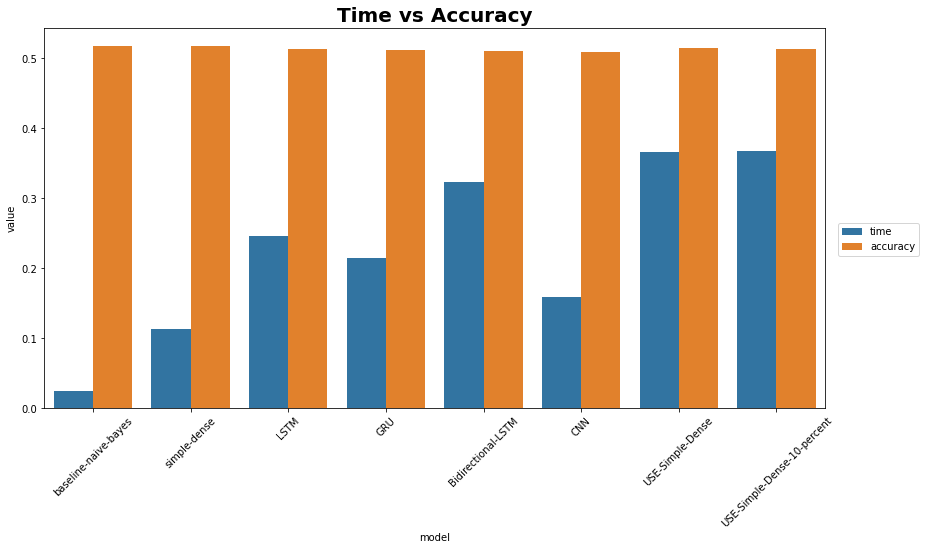

In [270]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(x='model', y='value', hue='metric', data=pred_perf_df, ax=ax)
plt.xticks(rotation=45);
plt.legend(bbox_to_anchor=(1.01, 0.5))
ax.set_title('Time vs Accuracy', fontdict=dict(weight='bold', size=20));